In [1]:
# Import Dependencies
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import requests
import json
import hvplot.pandas
from scipy.stats import linregress
import scipy.stats as st

# Import the API key
from config import api_key

In [2]:
# Read in our csv file with city info and put it into a dataframe
file_path = Path("worldcities_2023.csv")
city_df = pd.read_csv(file_path)

city_df

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,Tokyo,Tokyo,35.6897,139.6922,Japan,JP,JPN,Tōkyō,primary,37732000.0,1392685764
1,Jakarta,Jakarta,-6.1750,106.8275,Indonesia,ID,IDN,Jakarta,primary,33756000.0,1360771077
2,Delhi,Delhi,28.6100,77.2300,India,IN,IND,Delhi,admin,32226000.0,1356872604
3,Guangzhou,Guangzhou,23.1300,113.2600,China,CN,CHN,Guangdong,admin,26940000.0,1156237133
4,Mumbai,Mumbai,19.0761,72.8775,India,IN,IND,Mahārāshtra,admin,24973000.0,1356226629
...,...,...,...,...,...,...,...,...,...,...,...
44686,Numto,Numto,63.6667,71.3333,Russia,RU,RUS,Khanty-Mansiyskiy Avtonomnyy Okrug-Yugra,NaN,10.0,1643985006
44687,Nord,Nord,81.7166,-17.8000,Greenland,GL,GRL,NaN,NaN,10.0,1304217709
44688,Timmiarmiut,Timmiarmiut,62.5333,-42.2167,Greenland,GL,GRL,Kujalleq,NaN,10.0,1304206491
44689,San Rafael,San Rafael,-16.7795,-60.6799,Bolivia,BO,BOL,Santa Cruz,NaN,NaN,1068007388


In [3]:
# Filter only for cities in the US with a population of 100,000 residents or more
usa_df = city_df.loc[(city_df["country"] == "United States") & (city_df["population"] >= 100000)]

usa_df = usa_df.rename(columns={"admin_name": "state"})
usa_df["population"] = usa_df["population"].astype("int64")

usa_df

,city,city_ascii,lat,lng,country,iso2,iso3,state,capital,population,id
11,New York,New York,40.6943,-73.9249,United States,US,USA,New York,NaN,18972871,1840034016
33,Los Angeles,Los Angeles,34.1141,-118.4068,United States,US,USA,California,NaN,12121244,1840020491
55,Chicago,Chicago,41.8375,-87.6866,United States,US,USA,Illinois,NaN,8595181,1840000494
100,Miami,Miami,25.7840,-80.2101,United States,US,USA,Florida,NaN,5711945,1840015149
104,Dallas,Dallas,32.7935,-96.7667,United States,US,USA,Texas,NaN,5668165,1840019440
...,...,...,...,...,...,...,...,...,...,...,...
5953,Lee's Summit,Lee's Summit,38.9171,-94.3816,United States,US,USA,Missouri,NaN,100772,1840032155
5962,Quincy,Quincy,42.2506,-71.0187,United States,US,USA,Massachusetts,NaN,100544,1840000461
5974,San Angelo,San Angelo,31.4424,-100.4504,United States,US,USA,Texas,NaN,100330,1840022146
5976,Lynn,Lynn,42.4781,-70.9664,United States,US,USA,Massachusetts,NaN,100233,1840000409


In [4]:
# Get a statistical overview of our columns
usa_df.describe()

,lat,lng,population,id
count,476.000000,476.000000,4.760000e+02,4.760000e+02
mean,36.923922,-95.990705,5.433168e+05,1.840016e+09
std,5.356942,17.686915,1.335352e+06,1.227606e+04
min,21.329400,-157.846000,1.002020e+05,1.840000e+09
25%,33.469975,-115.338925,1.300660e+05,1.840007e+09
50%,37.090450,-92.354950,1.987120e+05,1.840018e+09
75%,40.815425,-81.142600,3.820475e+05,1.840021e+09
max,61.150800,-70.271500,1.897287e+07,1.840088e+09


In [5]:
# Ensure that all columns have the proper data-types
usa_df.dtypes

city           object
city_ascii     object
lat           float64
lng           float64
country        object
iso2           object
iso3           object
state          object
capital        object
population      int64
id              int64
dtype: object

In [6]:
# Add new Air Quality Index Level columns for each city in dataframe
usa_df["AQI"] = " "
usa_df["CO"] = " "
usa_df["NO"] = " "
usa_df["NO2"] = " "
usa_df["O3"] = " "
usa_df["SO2"] = " "
usa_df["PM2.5"] = " "
usa_df["PM10"] = " "
usa_df["NH3"] = " "

usa_df

,city,city_ascii,lat,lng,country,iso2,iso3,state,capital,population,id,AQI,CO,NO,NO2,O3,SO2,PM2.5,PM10,NH3
11,New York,New York,40.6943,-73.9249,United States,US,USA,New York,NaN,18972871,1840034016,,,,,,,,,
33,Los Angeles,Los Angeles,34.1141,-118.4068,United States,US,USA,California,NaN,12121244,1840020491,,,,,,,,,
55,Chicago,Chicago,41.8375,-87.6866,United States,US,USA,Illinois,NaN,8595181,1840000494,,,,,,,,,
100,Miami,Miami,25.7840,-80.2101,United States,US,USA,Florida,NaN,5711945,1840015149,,,,,,,,,
104,Dallas,Dallas,32.7935,-96.7667,United States,US,USA,Texas,NaN,5668165,1840019440,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5953,Lee's Summit,Lee's Summit,38.9171,-94.3816,United States,US,USA,Missouri,NaN,100772,1840032155,,,,,,,,,
5962,Quincy,Quincy,42.2506,-71.0187,United States,US,USA,Massachusetts,NaN,100544,1840000461,,,,,,,,,
5974,San Angelo,San Angelo,31.4424,-100.4504,United States,US,USA,Texas,NaN,100330,1840022146,,,,,,,,,
5976,Lynn,Lynn,42.4781,-70.9664,United States,US,USA,Massachusetts,NaN,100233,1840000409,,,,,,,,,


In [7]:
# Set base URL and params to search for current air pollution data
base_url = "http://api.openweathermap.org/data/2.5/air_pollution?"

params = {"appid":api_key}


# Print a message to follow up the air pollution search
print("Starting city air pollution details search:")

# Iterate through the usa_df dataframe
for index, row in usa_df.iterrows():
    
    # Get city name, latitude, and longitude values for each row in dataframe
    city = row["city"]
    lat = row["lat"]
    lng = row["lng"]
    
    # Add the current city's latitude and longitude to the params dictionary
    params["lat"] = lat
    params["lon"] = lng
    
    # Make an API request using params dictionary and store it into a json
    response = requests.get(base_url, params=params)
    data = response.json()
    #print(json.dumps(data, indent = 4))
    
    # Drill down to get the values we are looking for in the json and store those values in our dataframe
    try:
        usa_df.loc[index, "AQI"] = data["list"][0]["main"]["aqi"]
        usa_df.loc[index, "CO"] = data["list"][0]["components"]["co"]
        usa_df.loc[index, "NO"] = data["list"][0]["components"]["no"]
        usa_df.loc[index, "NO2"] = data["list"][0]["components"]["no2"]
        usa_df.loc[index, "O3"] = data["list"][0]["components"]["o3"]
        usa_df.loc[index, "SO2"] = data["list"][0]["components"]["so2"]
        usa_df.loc[index, "PM2.5"] = data["list"][0]["components"]["pm2_5"]
        usa_df.loc[index, "PM10"] = data["list"][0]["components"]["pm10"]
        usa_df.loc[index, "NH3"] = data["list"][0]["components"]["nh3"]
        
        
    except Exception as e:
        # If city is not found, log the error.
        print(f"{e.args} not found for {usa_df.loc[index, 'city']}")
        
    print(f"Appending results for {city}")

Starting city air pollution details search:
Appending results for New York
Appending results for Los Angeles
Appending results for Chicago
Appending results for Miami
Appending results for Dallas
Appending results for Houston
Appending results for Philadelphia
Appending results for Atlanta
Appending results for Washington
Appending results for Boston
Appending results for Phoenix
Appending results for Detroit
Appending results for Seattle
Appending results for San Francisco
Appending results for San Diego
Appending results for Minneapolis
Appending results for Brooklyn
Appending results for Tampa
Appending results for Denver
Appending results for Queens
Appending results for Baltimore
Appending results for Las Vegas
Appending results for St. Louis
Appending results for Portland
Appending results for Riverside
Appending results for Orlando
Appending results for Sacramento
Appending results for San Antonio
Appending results for San Jose
Appending results for Pittsburgh
Appending results 

Appending results for Erie
Appending results for Newport News
Appending results for Aurora
Appending results for Fort Lauderdale
Appending results for Vallejo
Appending results for Murfreesboro
Appending results for Spring Hill
Appending results for Tempe
Appending results for High Point
Appending results for Medford
Appending results for Danbury
Appending results for Elk Grove
Appending results for Ontario
Appending results for Frederick
Appending results for Vero Beach South
Appending results for Ocala
Appending results for Oceanside
Appending results for Rancho Cucamonga
Appending results for Garden Grove
Appending results for Cary
Appending results for Pembroke Pines
Appending results for Palmdale
Appending results for Manchester
Appending results for Lafayette
Appending results for Santa Cruz
Appending results for Marysville
Appending results for Muskegon
Appending results for Springfield
Appending results for Hayward
Appending results for New Bedford
Appending results for Alexand

#####  Air Quality Index. Possible values: 1, 2, 3, 4, 5. Where 1 = Good, 2 = Fair, 3 = Moderate, 4 = Poor, 5 = Very Poor.

In [8]:
# Preview the updated dataframe and sort the results by AQI in descending order
usa_df.head(20).sort_values(by="AQI", ascending=False)

,city,city_ascii,lat,lng,country,iso2,iso3,state,capital,population,id,AQI,CO,NO,NO2,O3,SO2,PM2.5,PM10,NH3
33,Los Angeles,Los Angeles,34.1141,-118.4068,United States,US,USA,California,NaN,12121244,1840020491,4,211.95,0.37,4.76,141.62,1.55,9.47,12.74,0.24
55,Chicago,Chicago,41.8375,-87.6866,United States,US,USA,Illinois,NaN,8595181,1840000494,3,467.3,0.27,28.79,104.43,6.14,14.71,16.84,1.19
286,Minneapolis,Minneapolis,44.9635,-93.2678,United States,US,USA,Minnesota,NaN,2856952,1840007830,3,400.54,0.5,26.39,108.72,3.31,9.75,10.42,1.71
11,New York,New York,40.6943,-73.9249,United States,US,USA,New York,NaN,18972871,1840034016,2,353.81,0,26.39,67.23,9.89,10.31,13.6,1.46
308,Denver,Denver,39.7620,-104.8758,United States,US,USA,Colorado,admin,2650725,1840018789,2,226.97,1.17,18.34,86.55,2.21,8.14,14.47,1.12
291,Brooklyn,Brooklyn,40.6501,-73.9496,United States,US,USA,New York,NaN,2736074,1840034030,2,353.81,0,26.39,67.23,9.89,10.31,13.6,1.46
253,San Diego,San Diego,32.8313,-117.1222,United States,US,USA,California,NaN,3084174,1840021990,2,185.25,0.35,2.74,91.55,0.95,9.68,16.3,0.02
237,San Francisco,San Francisco,37.7558,-122.4449,United States,US,USA,California,NaN,3290197,1840021543,2,178.58,0.09,0.53,73.67,0.71,2.38,4.11,0
223,Seattle,Seattle,47.6211,-122.3244,United States,US,USA,Washington,NaN,3438221,1840021117,2,198.6,0.5,5.27,61.51,1.52,1.82,2.07,0.17
219,Detroit,Detroit,42.3834,-83.1024,United States,US,USA,Michigan,NaN,3522856,1840003971,2,440.6,0.08,28.1,60.08,2.71,5.72,6.8,1.25


In [9]:
# Check which states in the US show the poorest AQI in descending order

state_aqi_df = usa_df.groupby("state")["AQI"].mean()

state_aqi_df.sort_values(ascending=False)

state
California              3.227273
Louisiana               3.000000
Kansas                  2.800000
Missouri                2.500000
Minnesota               2.400000
Arizona                 2.333333
Wisconsin               2.285714
Texas                   2.244444
Ohio                    2.222222
Idaho                   2.200000
Nevada                  2.111111
Colorado                2.066667
New York                2.041667
New Hampshire           2.000000
New Jersey              2.000000
New Mexico              2.000000
North Dakota            2.000000
Oklahoma                2.000000
Montana                 2.000000
Pennsylvania            2.000000
Rhode Island            2.000000
South Dakota            2.000000
Utah                    2.000000
West Virginia           2.000000
District of Columbia    2.000000
Delaware                2.000000
Alaska                  2.000000
Massachusetts           2.000000
Connecticut             2.000000
Maine                   2.000000
Mary

In [10]:
usa_df.loc[usa_df["state"] == "New Jersey"]

,city,city_ascii,lat,lng,country,iso2,iso3,state,capital,population,id,AQI,CO,NO,NO2,O3,SO2,PM2.5,PM10,NH3
2240,Trenton,Trenton,40.2237,-74.7641,United States,US,USA,New Jersey,admin,316436,1840001383,2,287.06,0,7.37,70.81,1.16,5.99,7.15,0.29
2299,Newark,Newark,40.7245,-74.1725,United States,US,USA,New Jersey,NaN,306247,1840002791,2,323.77,0,21.76,70.81,5.31,9.26,11.9,0.78
2422,Jersey City,Jersey City,40.7184,-74.0686,United States,US,USA,New Jersey,NaN,287146,1840003600,2,323.77,0,21.76,70.81,5.31,9.26,11.9,0.78
2839,Atlantic City,Atlantic City,39.3797,-74.4527,United States,US,USA,New Jersey,NaN,236314,1840003798,2,270.37,0,2.53,87.26,0.61,7.14,9.85,0
4000,Paterson,Paterson,40.9147,-74.1624,United States,US,USA,New Jersey,NaN,157927,1840000838,2,347.14,0,30.5,61.51,7.27,10.8,13.75,1.01
4572,Elizabeth,Elizabeth,40.6658,-74.1913,United States,US,USA,New Jersey,NaN,135772,1840003613,2,323.77,0,21.76,70.81,5.31,9.26,11.9,0.78
4726,Lakewood,Lakewood,40.0763,-74.2031,United States,US,USA,New Jersey,NaN,130221,1840081607,2,267.03,0,3.17,77.25,0.43,7.21,9.43,0.1
5650,Edison,Edison,40.5360,-74.3697,United States,US,USA,New Jersey,NaN,106909,1840081696,2,307.08,0,11.48,74.39,2.27,8.11,10.32,0.45
5839,Woodbridge,Woodbridge,40.5611,-74.2943,United States,US,USA,New Jersey,NaN,103353,1840081695,2,307.08,0,11.48,74.39,2.27,8.11,10.32,0.45


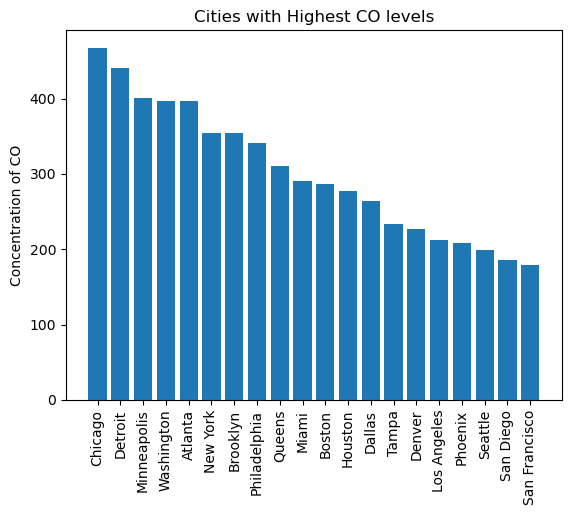

In [11]:
co_df = usa_df.head(20).sort_values(by="CO", ascending=False)

plt.bar(co_df["city"], co_df["CO"])
plt.title("Cities with Highest CO levels")
plt.ylabel("Concentration of CO")
plt.xticks(rotation = 90)
plt.show()

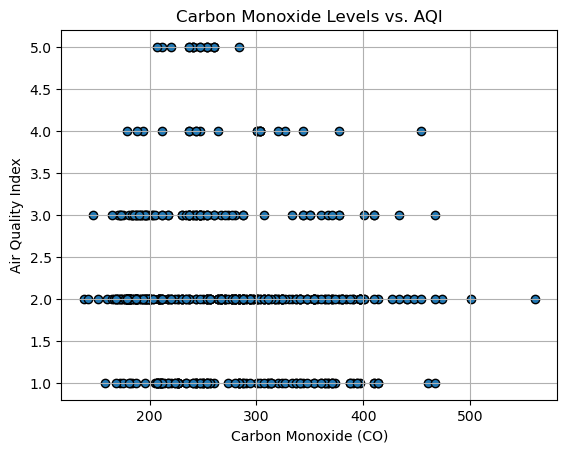

In [12]:
x = usa_df["CO"]
y = usa_df["AQI"]

plt.scatter(x, y, edgecolors="black")

# Incorporate the other graph properties
plt.title("Carbon Monoxide Levels vs. AQI")
plt.xlabel("Carbon Monoxide (CO)")
plt.ylabel("Air Quality Index")

plt.grid()

# Save the figure
plt.savefig("output_data/Fig3.png")

# Show plot
plt.show()

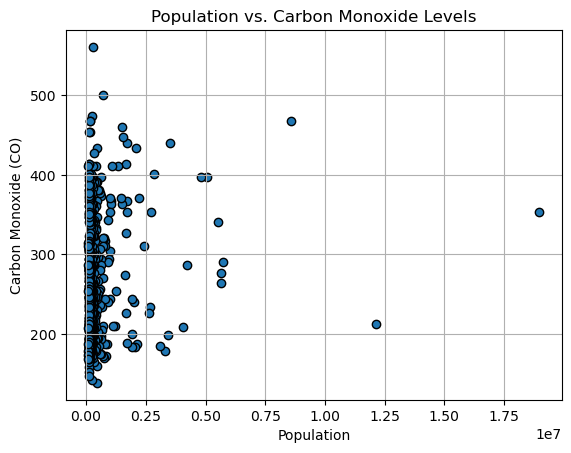

In [13]:
# Build scatter plot for 
x = usa_df["population"]
y = usa_df["CO"]

plt.scatter(x, y, edgecolors="black")

# Incorporate the other graph properties
plt.title("Population vs. Carbon Monoxide Levels")
plt.xlabel("Population")
plt.ylabel("Carbon Monoxide (CO)")

plt.grid()

# Save the figure
plt.savefig("output_data/Fig1.png")

# Show plot
plt.show()

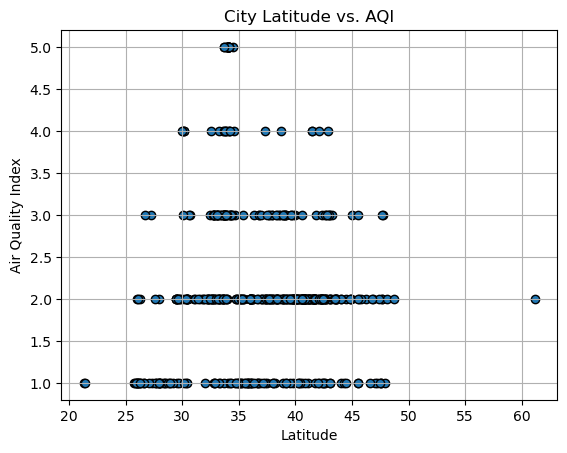

In [14]:
x = usa_df["lat"]
y = usa_df["AQI"]

plt.scatter(x, y, edgecolors="black")

# Incorporate the other graph properties
plt.title("City Latitude vs. AQI")
plt.xlabel("Latitude")
plt.ylabel("Air Quality Index")

plt.grid()

# Save the figure
plt.savefig("output_data/Fig2.png")

# Show plot
plt.show()

In [15]:
%%capture --no-display

# Configure the map plot
map_plot_1 = usa_df.hvplot.points("lng", "lat",  geo = True, tiles = "OSM", color = "city",
                                  hover_cols = ["city", "state", "population", "AQI"], frame_width=700, frame_height=500)

# Display the map
map_plot_1

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [lng,lat]   (city,state,population,AQI)

In [16]:
""" base_url = "http://api.openweathermap.org/data/2.5/air_pollution/history?"

start = 1672560000
end = 1689776640

params = {"start":start, 
          "end": end,
          "appid":api_key}

counter = 0

for index, row in usa_df.iterrows():
    lat = row["lat"]
    lng = row["lng"]
    
    params["lat"] = lat
    params["lon"] = lng
    
    response = requests.get(base_url, params=params)
    data = response.json()
    
    print(json.dumps(data, indent=4))
    
    
    try:
        city_df.loc[index, "CO"] = response["stations"][0]["CO"]
        
    except Exception as e:
        print(f"{e.args} not found for {city_df.loc[index, 'city']}") """

' base_url = "http://api.openweathermap.org/data/2.5/air_pollution/history?"\n\nstart = 1672560000\nend = 1689776640\n\nparams = {"start":start, \n          "end": end,\n          "appid":api_key}\n\ncounter = 0\n\nfor index, row in usa_df.iterrows():\n    lat = row["lat"]\n    lng = row["lng"]\n    \n    params["lat"] = lat\n    params["lon"] = lng\n    \n    response = requests.get(base_url, params=params)\n    data = response.json()\n    \n    print(json.dumps(data, indent=4))\n    \n    \n    try:\n        city_df.loc[index, "CO"] = response["stations"][0]["CO"]\n        \n    except Exception as e:\n        print(f"{e.args} not found for {city_df.loc[index, \'city\']}") '